# Load dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7

In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score, classification_report 

# Merge the dataset 

In [4]:
df1 = pd.read_csv("Credit_card.csv")
df2 = pd.read_csv("Credit_card_label.csv")

In [5]:
print(df1.shape)
df1.head(2)

(1548, 18)


,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [6]:
print(df2.shape)
df2.head(2)

(1548, 2)


,Ind_ID,label
0,5008827,1
1,5009744,1


In [7]:
df = pd.merge(df1, df2, on = "Ind_ID")
print(df.shape)
df.head(2)

(1548, 19)


,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


# Exploratory Data Analysis

In [8]:
df.isnull().sum()

Ind_ID               0
GENDER               7
Car_Owner            0
Propert_Owner        0
CHILDREN             0
Annual_income       23
Type_Income          0
EDUCATION            0
Marital_status       0
Housing_type         0
Birthday_count      22
Employed_days        0
Mobile_phone         0
Work_Phone           0
Phone                0
EMAIL_ID             0
Type_Occupation    488
Family_Members       0
label                0
dtype: int64

In [9]:
#fill Annual_Income with mean value
mean = df['Annual_income'].mean()
df['Annual_income'].fillna(mean, inplace = True)

In [10]:
df = df.dropna().reset_index().drop('index',axis=1)

In [11]:
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicated values : {df.duplicated().sum()}")

Missing values: 0
Duplicated values : 0


In [12]:
df = df.drop(['Ind_ID','Mobile_phone','Work_Phone','Birthday_count','Phone','EMAIL_ID','EDUCATION', 'Type_Occupation'],axis=1)

In [13]:
categorical = list(set(df.columns)- set(df.describe().columns))

for i in categorical:
    print(f'\nUnique values in {i}\n{df[i].unique()}\n-----------------------------------')


Unique values in GENDER
['M' 'F']
-----------------------------------

Unique values in Marital_status
['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
-----------------------------------

Unique values in Car_Owner
['Y' 'N']
-----------------------------------

Unique values in Housing_type
['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
-----------------------------------

Unique values in Type_Income
['Commercial associate' 'Pensioner' 'Working' 'State servant']
-----------------------------------

Unique values in Propert_Owner
['Y' 'N']
-----------------------------------


In [14]:
df['Marital_status'] = df.Marital_status.replace ({'Civil marriage':'Married', 'Widow':'Separated','Single / not married': 'Single'})
df['Marital_status'].unique()

array(['Married', 'Single', 'Separated'], dtype=object)

In [15]:
df.head(2)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,Marital_status,Housing_type,Employed_days,Family_Members,label
0,M,Y,Y,1,450000.0,Commercial associate,Married,House / apartment,-678,3,1
1,M,Y,Y,1,450000.0,Pensioner,Married,House / apartment,-678,3,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GENDER          1040 non-null   object 
 1   Car_Owner       1040 non-null   object 
 2   Propert_Owner   1040 non-null   object 
 3   CHILDREN        1040 non-null   int64  
 4   Annual_income   1040 non-null   float64
 5   Type_Income     1040 non-null   object 
 6   Marital_status  1040 non-null   object 
 7   Housing_type    1040 non-null   object 
 8   Employed_days   1040 non-null   int64  
 9   Family_Members  1040 non-null   int64  
 10  label           1040 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 89.5+ KB


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CHILDREN,1040.0,0.492308,0.841614,0.0,0.0,0.0,1.0,14.0
Annual_income,1040.0,199984.819128,120634.706977,36000.0,135000.0,180000.0,225000.0,1575000.0
Employed_days,1040.0,-2684.473077,2389.362854,-14887.0,-3613.5,-1953.0,-974.0,-73.0
Family_Members,1040.0,2.267308,0.995509,1.0,2.0,2.0,3.0,15.0
label,1040.0,0.109615,0.312560,0.0,0.0,0.0,0.0,1.0


<Axes: >

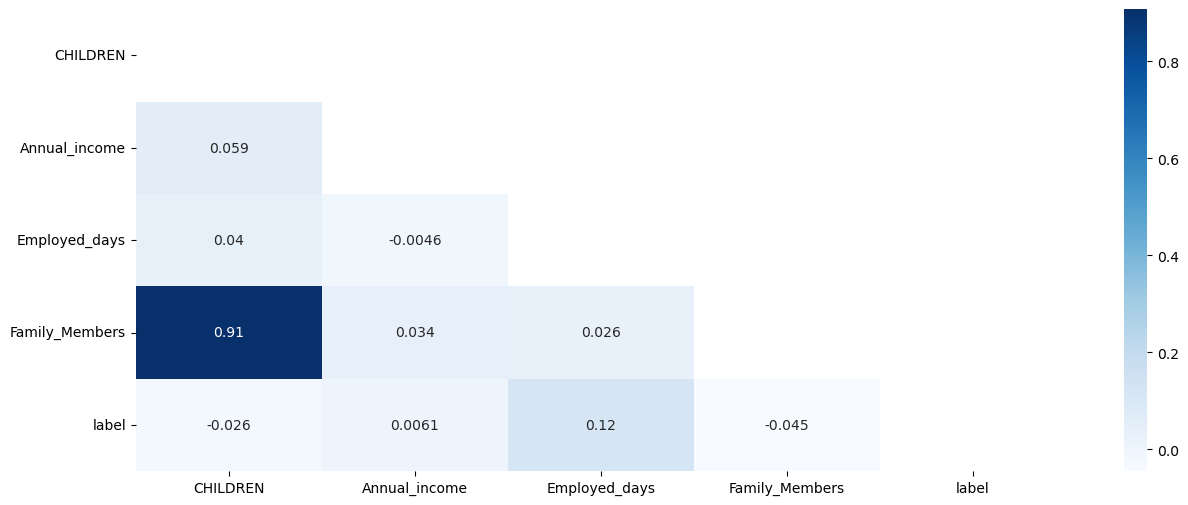

In [18]:
# Having a look at the correlation matrix

fig= plt.subplots(figsize=(15, 6))
corr = df[df.describe().columns].corr()
sns.heatmap(corr, annot=True, mask=np.triu(corr),cmap ="Blues")

# Data Split & Visualization

In [19]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

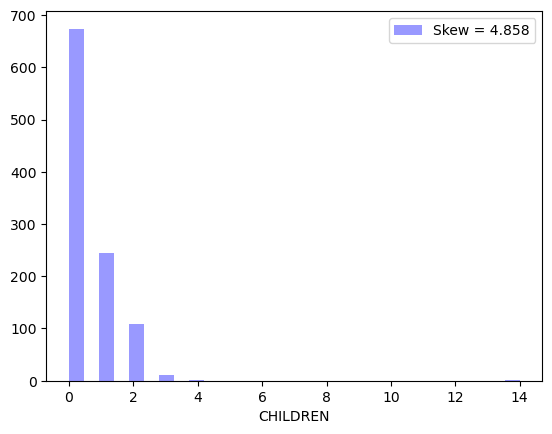

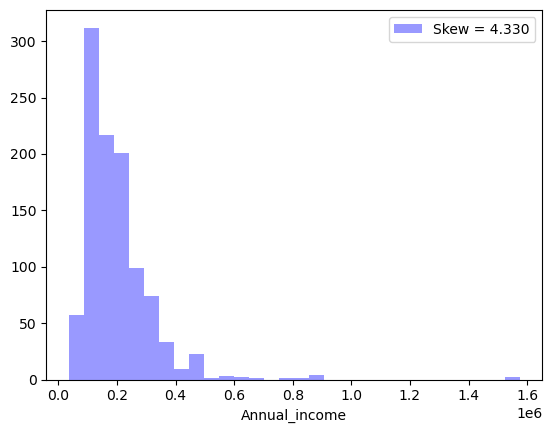

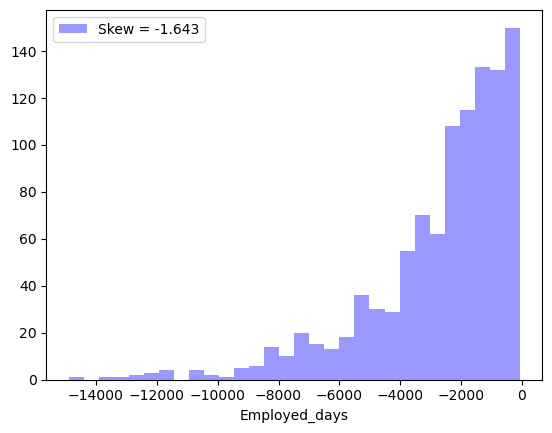

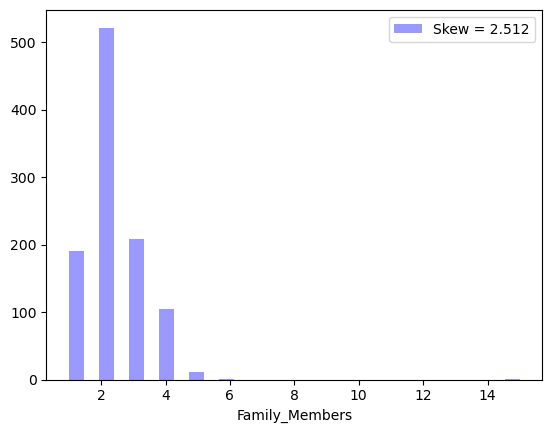

In [20]:
num = [i for i in X.columns if X[i].dtypes != 'object']
for i in num:
    skew = df[i].skew()
    sns.distplot(df[i], kde= False, label='Skew = %.3f' %(skew), color = 'blue', bins=30)
    plt.legend(loc='best')
    plt.show()

# Data Mapping

In [21]:
categorical = list((set(X.columns)-set(X.describe().columns))) # Get
maplist = []

def mapLabel(x,col):
    maplist=[]
    count=0
    unique = df[col].unique()  
    
    for i in df[col].unique():
        x[col]=x[col].replace(i,count)
        count+=1
    
    maplist+=[pd.DataFrame(dict({f'{col}':unique,'map':list(range(count))})).set_index(f'{col}')]
    return maplist

for i in categorical:
    maplist+= mapLabel(X,i)
    
for i in range(len(maplist)):
    print(maplist[i].to_dict()['map'])

{'M': 0, 'F': 1}
{'Married': 0, 'Single': 1, 'Separated': 2}
{'Y': 0, 'N': 1}
{'House / apartment': 0, 'Rented apartment': 1, 'Municipal apartment': 2, 'With parents': 3, 'Co-op apartment': 4, 'Office apartment': 5}
{'Commercial associate': 0, 'Pensioner': 1, 'Working': 2, 'State servant': 3}
{'Y': 0, 'N': 1}


<Axes: >

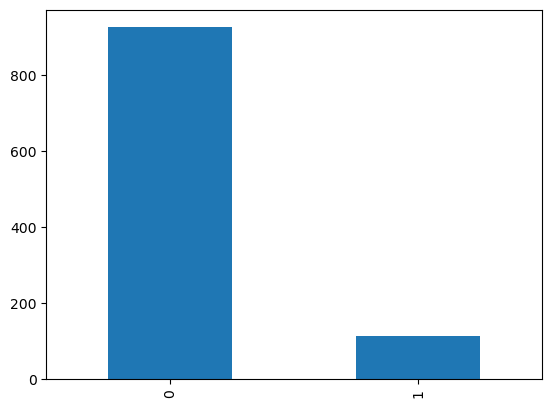

In [22]:
y.value_counts().plot(kind='bar')

In [23]:
#target is imbalance, need oversampling

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

<Axes: >

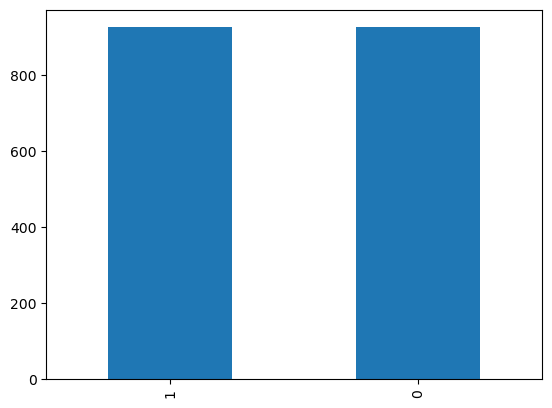

In [24]:
y.value_counts().plot(kind='bar')

In [25]:
X.head(2)

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,Marital_status,Housing_type,Employed_days,Family_Members
0,0,0,0,1,450000.0,0,0,0,-678,3
1,0,0,0,1,450000.0,1,0,0,-678,3


# Train Test Split & StandardScaling feature(X)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print("Shape of train data: ", X_train.shape[0])
print("Shape of test data: ", X_test.shape[0])

Shape of train data:  1296
Shape of test data:  556


In [27]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model building with K value

KNN Classifier Accuracy 86.87


,Metrics,KNN Classifier
0,Precision(%),89.0
1,Recall(%),87.0
2,F1-Score(%),87.0


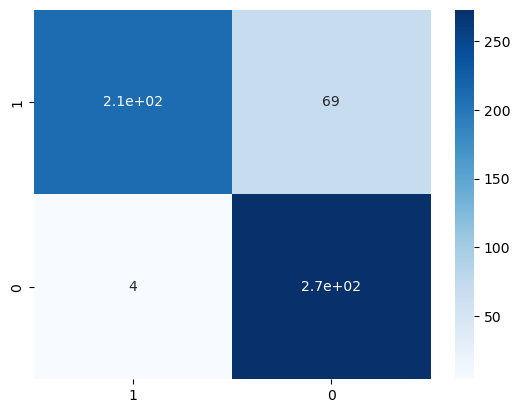

In [28]:
# KNN Classifier object
knn_model = KNeighborsClassifier(n_neighbors = 3, metric='minkowski', p=2)

# train the model on train set
model = knn_model.fit(X_train, y_train)
#predictions on test data
knn_predictions = model.predict(X_test)

# accuracy score
knn_accuracy = round(accuracy_score(y_test, knn_predictions)*100,2)
#confusion_matrix
knn_cm = confusion_matrix(y_test,knn_predictions)
print('KNN Classifier Accuracy', knn_accuracy)

sns.heatmap(knn_cm, annot = True, cmap = 'Blues', 
            xticklabels = y_test.unique(), yticklabels = y_test.unique())

# classification Report
knn_precision = round(precision_score(y_test, knn_predictions,average = 'macro'),2)
knn_recall = round(recall_score(y_test, knn_predictions, average = 'macro'),2)
knn_f1 = round(f1_score(y_test, knn_predictions, average = 'macro'),2)
KNN_results = pd.DataFrame({"Metrics": pd.Series(['Precision(%)','Recall(%)','F1-Score(%)']),
                        "KNN Classifier": pd.Series([knn_precision, knn_recall, knn_f1])})
KNN_results['KNN Classifier'] = KNN_results['KNN Classifier'].apply(lambda x: round(x*100,0))
KNN_results

# Model building using cross validation

In [29]:
import optuna
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    weights = {
        0:trial.suggest_float(0,0,2),
        1:trial.suggest_float(1,0,2),
    }
    params = {
              'class_weight':weights,
              'max_depth': trial.suggest_int('max_depth',1,20),
              'max_leaf_nodes':trial.suggest_categorical('max_leaf_nodes',(2**np.arange(1,6,1)).tolist()),
              'learning_rate': trial.suggest_float('learning_rate',0,0.1),
              'l2_regularization': trial.suggest_float('l2_regularization',0,0.5),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,20),
              'tol': trial.suggest_categorical('tol',[1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11]),
              'warm_start':True,
              'max_iter': trial.suggest_int('max_iter',1,100),
              'random_state': trial.suggest_int('random_state',1,200),
              }
    k = trial.suggest_int('k',5,11)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    model = HistGradientBoostingClassifier(**params)
    score =cross_val_score(model, X, y, cv=kf)
    mean_cross_val_score = score.mean()
    return mean_cross_val_score
study = optuna.create_study(direction="maximize")

[I 2023-09-30 23:39:29,415] A new study created in memory with name: no-name-bb371fae-05dd-452d-9bb3-b811b7fc6a15


In [30]:
params = {
    'class_weight':{0: 1.6488803263787362,1: 0.8293903841178812},
    'max_depth': 15,
    'max_leaf_nodes': 32,
    'learning_rate': 0.09993713196468443,
    'l2_regularization': 0.444687185132232,
    'min_samples_leaf': 15,
    'tol': 1e-07,
    'max_iter': 98,
    'random_state': 37
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = HistGradientBoostingClassifier(**params)
score =cross_val_score(model, X, y, cv=kf)
print(score)
print(f"Score Mean {score.mean()}")

[0.96774194 0.94623656 0.99459459 0.98378378 0.96216216 0.95675676
 0.95675676 0.94594595 0.97837838 0.94594595]
Score Mean 0.9638302818947981
